In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [321]:
companies_selected = pd.read_excel("Companies.xlsx")

In [322]:
companies_selected.shape

(79, 5)

In [323]:
companies_selected.head()

,Company Name,Industry,Beta Value,Grade,TSR
0,NextEra Energy (NEE),Utilities,0.49,B,53.47
1,Duke Energy (DUK),Utilities,0.38,C,57.51
2,Atmos Energy (ATO),Utilities,0.50,B,54.13
3,Avangrid (AGR),Utilities,0.34,A,-8.57
4,Otter Tail (OTTR),Utilities,0.69,A,87.72


In [324]:
# since TSR is in % we will grade wight in % as well
grade_weight = {"A": 90, "B": 80, "C": 70, "D": 60, "E": 50, "F": 40}
companies_selected["GradeWeight"] = companies_selected["Grade"].map(grade_weight)

In [325]:
def calculate_grade_score(data, x):
    return (1 - x) * data["TSR"] + x * data["GradeWeight"]

In [ ]:
def monte_carlo_simulation(
    data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
):
    best_portfolio = None
    best_portfolio_beta = float("inf")
    best_run = None

    for iteration in range(
        65000, 80000
    ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
        weight_factor = iteration / 100000  # Fraction for Grade Score calculation

        # Normalize TSR:
        data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
        data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

        # Calculate Grade Score:
        data["Grade Score"] = data.apply(
            calculate_grade_score, axis=1, args=(weight_factor,)
        )

        # Calculate Weight:
        data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

        # Apply industry-level restrictions:
        data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
            "sum"
        )
        data["Allocation_by_restriction"] = np.where(
            data["Industry Allocation"] > max_industry_allocation,
            max_industry_allocation,
            data["Industry Allocation"],
        )

        # Normalize Weights based on restrictions:
        data["Normalised Weight"] = np.where(
            data["Allocation_by_restriction"] == max_industry_allocation,
            (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
            data["Weight"],
        )

        # Calculate Portfolio Beta:
        portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

        # Check if this portfolio is better:
        if portfolio_beta < best_portfolio_beta:
            test = weight_factor
            best_portfolio_beta = portfolio_beta
            best_run = iteration
            best_portfolio = data.copy()
            
    return test, best_run, best_portfolio_beta, best_portfolio

In [327]:
test, run_no, final_beta, ideal_portfolio = monte_carlo_simulation(companies_selected)

65000 0.8960902104464805


In [328]:
final_beta

0.8960902104464805

In [329]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.008818,0.081304,0.081304,0.008818
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008184,0.081304,0.081304,0.008184
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.008847,0.081304,0.081304,0.008847
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.006921,0.081304,0.081304,0.006921
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011123,0.081304,0.081304,0.011123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,222.00,60,694.10,0.319839,116.7000,0.014552,0.095134,0.095134,0.014552
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,59.00,90,694.10,0.085002,79.1500,0.009870,0.095134,0.095134,0.009870
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,38.00,80,694.10,0.054747,65.3000,0.008143,0.095134,0.095134,0.008143


In [330]:
ideal_portfolio.groupby("Industry")["Allocation_by_restriction"].mean()

Industry
Consumer Staples    0.095134
Energy              0.109765
Finance             0.129784
Healthcare          0.127471
Industruals         0.109167
Real Estate         0.078241
Technology          0.160000
Utilities           0.081304
Name: Allocation_by_restriction, dtype: float64

In [331]:
0.077816 + 0.117657 + 0.139116 + 0.136636 + 0.069275 + 0.083867 + 0.160000 + 0.087150

0.8715170000000001

In [332]:
left_over = 1 - ideal_portfolio["Normalised Weight"].sum()
left_over

0.10913266324038762

In [333]:
no_change = len(ideal_portfolio[ideal_portfolio["Allocation_by_restriction"] >= 0.16])

In [334]:
change = len(ideal_portfolio)

In [335]:
addition = left_over / (change - no_change)

In [336]:
addition

0.0015590380462912517

In [337]:
(ideal_portfolio["Allocation_by_restriction"] > 0.1599).sum()

9

In [338]:
ideal_portfolio["final_weight"] = np.where(
    ideal_portfolio["Allocation_by_restriction"] >= 0.1600,
    ideal_portfolio["Normalised Weight"],
    ideal_portfolio["Normalised Weight"] + addition,
)

In [339]:
ideal_portfolio["final_weight"].sum()

1.0

In [340]:
ideal_portfolio.groupby("Industry")["final_weight"].sum()

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [341]:
a = ideal_portfolio

In [342]:
# -------------------------------------------------------------- for capping stocks at 4.5%

In [343]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 4.5)

In [344]:
ideal_portfolio.sort_values("final_weight", ascending=False)[
    ["Company Name", "final_weight"]
]

,Company Name,final_weight
44,NVDA,0.073294
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [345]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 0.045)

In [346]:
ideal_portfolio.sort_values("Capped_weight", ascending=False)[
    ["Company Name", "Capped_weight"]
]

,Company Name,Capped_weight
44,NVDA,0.045000
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [347]:
while True:
    industry_totals = ideal_portfolio.groupby("Industry")["final_weight"].transform(
        "sum"
    )
    capped_totals = ideal_portfolio.groupby("Industry")["Capped_weight"].transform(
        "sum"
    )
    excess_weight = industry_totals - capped_totals

    if (excess_weight <= 0).all():
        break

    # Identify eligible stocks (below cap) for redistribution
    eligible = ideal_portfolio["Capped_weight"] < 0.045
    eligible_totals = (
        ideal_portfolio[eligible].groupby("Industry")["Capped_weight"].transform("sum")
    )

    # Redistribute proportionally among eligible stocks
    redistribution = (
        ideal_portfolio["Capped_weight"] / eligible_totals
    ) * excess_weight
    redistribution = redistribution.fillna(
        0
    )  # Avoid NaN for industries with no eligible stocks
    ideal_portfolio.loc[eligible, "Capped_weight"] += redistribution[eligible]

    # Reapply the cap
    ideal_portfolio["Capped_weight"] = np.minimum(
        ideal_portfolio["Capped_weight"], 0.045
    )

In [348]:
ideal_portfolio["Capped_weight"] *= 100

### VERIFY PORTFOLIO CONSTRATINTS -

In [349]:
round(ideal_portfolio["Capped_weight"].sum(), 2) == 100.00

True

In [350]:
ideal_portfolio.sort_values(by="Capped_weight", ascending=False)

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
44,NVDA,Technology,1.76,C,2694.86,70,4829.52,0.557997,988.7010,0.123286,0.269133,0.160000,0.073294,0.073294,4.500000
40,TSLA,Technology,2.12,A,1236.11,90,4829.52,0.255949,491.1385,0.061242,0.269133,0.160000,0.036409,0.036409,4.500000
25,Eli Lilly and Company (LLY),Healthcare,0.42,C,675.16,70,1435.04,0.470482,281.8060,0.035140,0.127471,0.127471,0.035140,0.036699,3.669877
10,Interactive Brokers (IBKR),Finance,0.79,D,303.51,60,1525.19,0.198998,145.2285,0.018109,0.129784,0.129784,0.018109,0.019668,1.966827
11,LPL Financial (LPLA),Finance,0.85,C,276.95,70,1525.19,0.181584,142.4325,0.017761,0.129784,0.129784,0.017761,0.019320,1.931962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,EQR,Real Estate,0.85,C,2.70,70,307.04,0.008794,46.4450,0.005791,0.078241,0.078241,0.005791,0.007350,0.735049
57,PEAK,Real Estate,0.75,B,-22.76,80,307.04,-0.074127,44.0340,0.005491,0.078241,0.078241,0.005491,0.007050,0.704985
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249,0.005808,0.580776
48,COIN,Technology,3.34,B,-10.57,80,4829.52,-0.002189,48.3005,0.006023,0.269133,0.160000,0.003581,0.003581,0.498316


In [351]:
a = ideal_portfolio.groupby("Industry")["final_weight"].sum()
a

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [352]:
# ---------------------------------------------------------------------- EVERYTHING BELOW IS FOR TESTING OUT PORTFOLIO

In [353]:
final_port = ideal_portfolio[["Company Name", "Capped_weight"]]
ticker_map = pd.read_excel("ticker_map.xlsx")
mapping_dict = dict(zip(ticker_map["Company Name"], ticker_map["Ticker"]))
final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)

final_port = final_port.set_index("Ticker")
final_port

C:\Users\asus\AppData\Local\Temp\ipykernel_11588\3355036518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)


,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.037676
DUK,Duke Energy (DUK),0.974257
ATO,Atmos Energy (ATO),1.040557
AGR,Avangrid (AGR),0.847966
OTTR,Otter Tail (OTTR),1.268206
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863


In [386]:
start_date = pd.to_datetime("today")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=29), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),0.974257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.040557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.847966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.268206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### USE THISS

import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


def get_returns(ticker, checkdate, intvl, start_of_year, mth, dys):
    # Calculate the start of the year for the given date
    try:
        # start_of_year = "2024-01-01"

        checkdate = checkdate + relativedelta(months=mth, days=dys)

        # Fetch data using yfinance
        data = yf.download(ticker, start=start_of_year, end=checkdate, interval=intvl)

        # Get the adjusted close price on the first day of the year
        start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

        # Calculate the return as the percentage change from the start of the year
        current_price = data["Adj Close"].iloc[-1]  # Price on the current date

        pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

        return pct_change

    except Exception as e:
        # Catch the specific error for failed downloads
        print(f"Failed to download data for {ticker}: {e}")
        return None


for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(
                indx,
                month,
                intvl="1d",
                start_of_year=datetime.today() - timedelta(days=30),
                mth=0,
                dys=1,
            ).values[0]

a = df_updated
df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,-4.912605,-4.784995,-1.786406,-1.786406,-1.786406,-3.138960,-5.244357,...,-1.552099,-0.460234,0.862851,0.862851,1.055536,1.055536,1.055536,-0.999742,-2.001690,-2.001690
DUK,Duke Energy (DUK),0.974257,NaN,0.986490,-1.279768,0.631003,0.631003,0.631003,-0.053323,-0.568787,...,3.178225,5.008517,5.349452,5.349452,5.017491,5.017491,5.017491,3.339721,1.958029,1.958029
ATO,Atmos Energy (ATO),1.040557,NaN,0.878916,2.738442,4.735971,4.735971,4.735971,6.130604,6.646333,...,9.723124,9.832722,10.636387,10.636387,10.556031,10.556031,10.556031,8.539538,6.691093,6.691093
AGR,Avangrid (AGR),0.847966,NaN,0.000000,0.281047,0.899385,0.899385,0.899385,0.730740,0.730740,...,1.602025,1.658226,1.602025,1.602025,1.461491,1.461491,1.461491,1.603751,1.489938,1.489938
OTTR,Otter Tail (OTTR),1.268206,NaN,8.901064,5.042659,0.674902,0.674902,0.674902,3.692865,1.693627,...,4.959083,2.768701,3.601295,3.601295,3.293875,3.293875,3.293875,3.614107,3.421966,3.421966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,1.487466,3.144219,6.515284,6.515284,6.515284,5.282878,5.226449,...,8.444029,9.641450,8.518512,8.518512,9.684336,9.684336,9.684336,10.036452,10.843389,10.843389
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,-5.597557,-4.792683,-6.158540,-6.158540,-6.158540,-6.963414,-8.390241,...,-6.597565,-8.975611,-6.999997,-6.999997,-5.768297,-5.768297,-5.768297,-5.134145,-3.634150,-3.634150
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.135402,0.178489,1.649439,1.649439,1.649439,1.581738,1.421712,...,2.363375,2.997298,2.874199,2.874199,2.886511,2.886511,2.886511,2.498768,2.861896,2.861896


In [390]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"])
df_updated

,Company Name,Capped_weight,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,-5.097695,-4.965277,-1.853711,-1.853711,-1.853711,-3.257225,-5.441946,...,-1.610577,-0.477574,0.895360,0.895360,1.095304,1.095304,1.095304,-1.037409,-2.077106,-2.077106
DUK,Duke Energy (DUK),0.974257,NaN,0.961094,-1.246823,0.614758,0.614758,0.614758,-0.051951,-0.554145,...,3.096407,4.879582,5.211739,5.211739,4.888325,4.888325,4.888325,3.253746,1.907623,1.907623
ATO,Atmos Energy (ATO),1.040557,NaN,0.914562,2.849504,4.928048,4.928048,4.928048,6.379243,6.915888,...,10.117464,10.231507,11.067766,11.067766,10.984151,10.984151,10.984151,8.885875,6.962463,6.962463
AGR,Avangrid (AGR),0.847966,NaN,0.000000,0.238318,0.762648,0.762648,0.762648,0.619642,0.619642,...,1.358463,1.406119,1.358463,1.358463,1.239294,1.239294,1.239294,1.359926,1.263417,1.263417
OTTR,Otter Tail (OTTR),1.268206,NaN,11.288382,6.395130,0.855915,0.855915,0.855915,4.683313,2.147867,...,6.289139,3.511283,4.567183,4.567183,4.177312,4.177312,4.177312,4.583432,4.339758,4.339758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,2.396444,5.065625,10.496719,10.496719,10.496719,8.511200,8.420288,...,13.604103,15.533257,13.724102,13.724102,15.602352,15.602352,15.602352,16.169643,17.469692,17.469692
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,-3.250928,-2.783476,-3.576734,-3.576734,-3.576734,-4.044185,-4.872852,...,-3.831709,-5.212821,-4.065432,-4.065432,-3.350090,-3.350090,-3.350090,-2.981789,-2.110628,-2.110628
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.154746,0.203988,1.885082,1.885082,1.885082,1.807709,1.624822,...,2.701013,3.425501,3.284815,3.284815,3.298885,3.298885,3.298885,2.855748,3.270755,3.270755


### SECTOR PERFORMANCE -

In [391]:
df_sectors = ["SPY", "XLI", "XLP", "XLE", "XLF", "XLV", "XLRE", "XLK", "XLU"]

df_sectors = pd.DataFrame(df_sectors, index=df_sectors)

start_date = pd.to_datetime("today")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=30), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=df_sectors.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_sectors = pd.concat([df_sectors, new_columns], axis=1)
df_sectors = df_sectors.drop(df_sectors.columns[0], axis=1)
df_sectors


for indx in df_sectors.index:
    for months in df_sectors.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object
        df_sectors.at[indx, months] = get_returns(
            indx,
            month,
            intvl="1d",
            start_of_year=datetime.today() - timedelta(days=30),
            mth=0,
            dys=1,
        ).values[0]

df_sectors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
SPY,NaN,NaN,NaN,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,5.984447
XLI,NaN,NaN,NaN,5.020171,6.148211,6.148211,6.148211,6.969970,6.051103,6.275208,...,7.231430,7.358439,6.962492,6.962492,7.567612,7.567612,7.567612,6.775730,6.103390,6.103390
XLP,NaN,NaN,NaN,-0.647013,0.559907,0.559907,0.559907,0.211519,0.323497,0.622123,...,2.388949,2.811988,3.023517,3.023517,3.546097,3.546097,3.546097,3.421675,2.886649,2.886649
XLE,NaN,NaN,NaN,3.974542,4.666741,4.666741,4.666741,5.258456,4.700233,5.515242,...,6.453052,6.307917,6.196275,6.196275,6.654013,6.654013,6.654013,5.526401,5.515242,5.515242
XLF,NaN,NaN,NaN,5.337081,6.287813,6.287813,6.287813,7.800347,7.476238,7.541058,...,10.328441,10.544514,10.760587,10.760587,10.933452,10.933452,10.933452,9.831468,9.010376,9.010376
XLV,NaN,NaN,NaN,1.594329,2.323355,2.323355,2.323355,1.723785,0.306600,0.040879,...,-0.940250,-0.408807,0.122636,0.122636,0.436056,0.436056,0.436056,0.258901,0.034069,0.034069
XLRE,NaN,NaN,NaN,-0.115694,1.596480,1.596480,1.596480,0.717255,-0.555302,0.231371,...,3.378063,3.887090,4.604345,4.604345,4.118461,4.118461,4.118461,2.545114,1.943545,1.943545
XLK,NaN,NaN,NaN,6.114236,5.998032,5.998032,5.998032,5.412533,5.546611,5.180118,...,4.402427,4.925355,3.504065,3.504065,4.465000,4.465000,4.465000,5.457223,5.837131,5.837131
XLU,NaN,NaN,NaN,0.634722,2.564771,2.564771,2.564771,2.849747,1.670986,1.489639,...,5.699484,7.383426,7.383426,7.383426,7.422284,7.422284,7.422284,5.116586,4.209845,4.209845


In [392]:
df_sectors = df_sectors.fillna(0)
df_sectors

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
SPY,0.0,0.0,0.0,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,5.984447
XLI,0.0,0.0,0.0,5.020171,6.148211,6.148211,6.148211,6.969970,6.051103,6.275208,...,7.231430,7.358439,6.962492,6.962492,7.567612,7.567612,7.567612,6.775730,6.103390,6.103390
XLP,0.0,0.0,0.0,-0.647013,0.559907,0.559907,0.559907,0.211519,0.323497,0.622123,...,2.388949,2.811988,3.023517,3.023517,3.546097,3.546097,3.546097,3.421675,2.886649,2.886649
XLE,0.0,0.0,0.0,3.974542,4.666741,4.666741,4.666741,5.258456,4.700233,5.515242,...,6.453052,6.307917,6.196275,6.196275,6.654013,6.654013,6.654013,5.526401,5.515242,5.515242
XLF,0.0,0.0,0.0,5.337081,6.287813,6.287813,6.287813,7.800347,7.476238,7.541058,...,10.328441,10.544514,10.760587,10.760587,10.933452,10.933452,10.933452,9.831468,9.010376,9.010376
XLV,0.0,0.0,0.0,1.594329,2.323355,2.323355,2.323355,1.723785,0.306600,0.040879,...,-0.940250,-0.408807,0.122636,0.122636,0.436056,0.436056,0.436056,0.258901,0.034069,0.034069
XLRE,0.0,0.0,0.0,-0.115694,1.596480,1.596480,1.596480,0.717255,-0.555302,0.231371,...,3.378063,3.887090,4.604345,4.604345,4.118461,4.118461,4.118461,2.545114,1.943545,1.943545
XLK,0.0,0.0,0.0,6.114236,5.998032,5.998032,5.998032,5.412533,5.546611,5.180118,...,4.402427,4.925355,3.504065,3.504065,4.465000,4.465000,4.465000,5.457223,5.837131,5.837131
XLU,0.0,0.0,0.0,0.634722,2.564771,2.564771,2.564771,2.849747,1.670986,1.489639,...,5.699484,7.383426,7.383426,7.383426,7.422284,7.422284,7.422284,5.116586,4.209845,4.209845


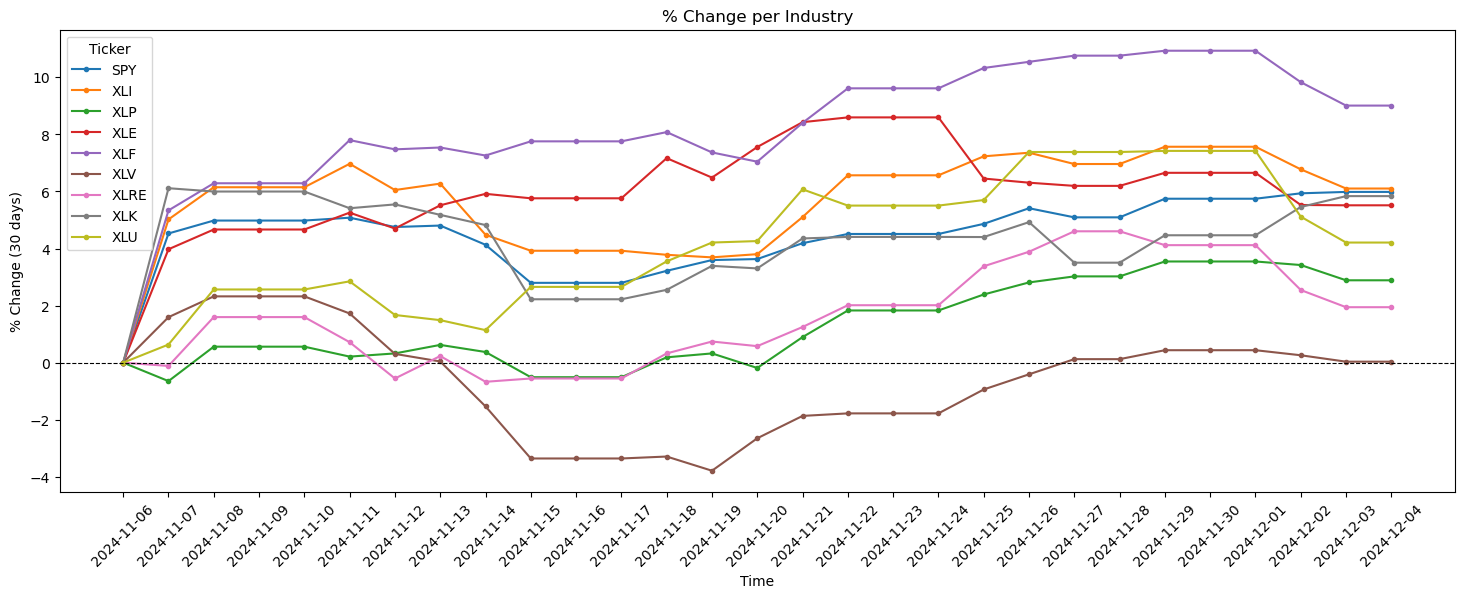

<Figure size 640x480 with 0 Axes>

In [393]:
plt.figure(figsize=(18, 6))
for ticker in df_sectors.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_sectors.columns[2:],
        df_sectors.loc[ticker].values[2:],
        label=ticker,
        marker="o",
        markersize=3,
    )

plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.xticks(rotation=45)
plt.title("% Change per Industry")
plt.show()
plt.savefig("sector_returns")

In [394]:
sect_returns = df_sectors[1:][df_sectors.columns[-1]]
sect_returns.mean()
sect_returns

XLI     6.103390
XLP     2.886649
XLE     5.515242
XLF     9.010376
XLV     0.034069
XLRE    1.943545
XLK     5.837131
XLU     4.209845
Name: 2024-12-04, dtype: float64

avg sect return (unweighted) is 5.57 (as of 12/03)

### PORTFOLIO VS SPY -

In [ ]:
a = df_updated

In [396]:
# Sum the values of each column (from the 3rd column onward)
column_wavg = df_updated.iloc[:, 2:].mean(axis=0)

# Create a new DataFrame with the same columns
df_avgs = pd.DataFrame(
    column_wavg
).T  # Transpose to match the structure of the original DataFrame
df_avgs.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_avgs.index = ["portfolio"]
spy_values = [np.NAN, np.NAN, np.NAN]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns(
        "SPY",
        month,
        intvl="1d",
        start_of_year=datetime.today() - timedelta(days=30),
        mth=0,
        dys=1,
    ).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_avgs = pd.concat([df_avgs, spy_values])
df_avgs

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,2024-11-14,...,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,Company Name,Capped_weight
portfolio,NaN,5.790713,6.035509,7.750485,7.750485,7.750485,9.079599,7.795341,7.688841,6.670685,...,9.897768,9.897768,10.610299,10.610299,10.610299,10.349516,10.082678,10.082678,NaN,NaN
SPY,NaN,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,4.131198,...,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,5.984447,NaN,NaN


In [397]:
df_avgs = df_avgs.fillna(0)
df_avgs

,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,2024-11-14,...,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,Company Name,Capped_weight
portfolio,0.0,5.790713,6.035509,7.750485,7.750485,7.750485,9.079599,7.795341,7.688841,6.670685,...,9.897768,9.897768,10.610299,10.610299,10.610299,10.349516,10.082678,10.082678,0.0,0.0
SPY,0.0,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,4.131198,...,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,5.984447,0.0,0.0


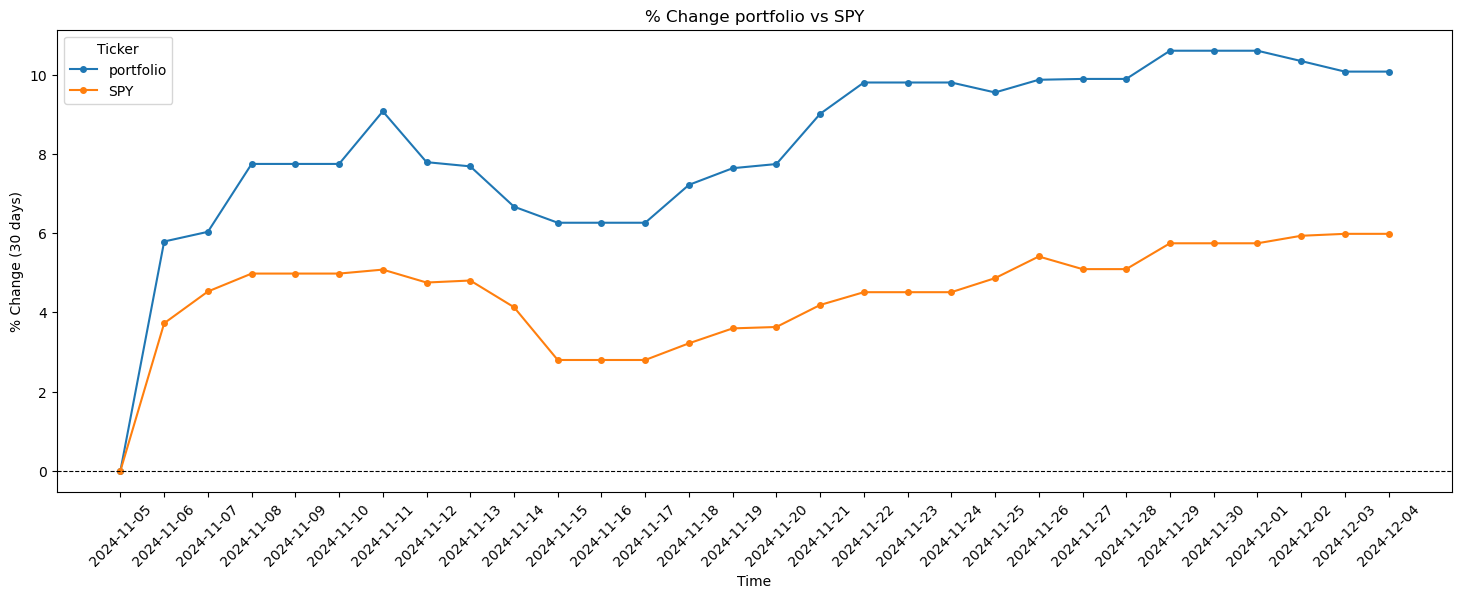

In [402]:
plt.figure(figsize=(18, 6))
for ticker in df_avgs.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_avgs.columns[:-2],
        df_avgs.loc[ticker].values[:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.title("% Change portfolio vs SPY")
plt.xticks(rotation=45)
plt.show()

### YEARLY

In [403]:
df_updated = df_updated[["Company Name", "Capped_weight"]]
df_updated

,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.037676
DUK,Duke Energy (DUK),0.974257
ATO,Atmos Energy (ATO),1.040557
AGR,Avangrid (AGR),0.847966
OTTR,Otter Tail (OTTR),1.268206
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863


In [404]:
start_date = "2023-12-01"

# Generate the first day of each month, starting from the start_date to the end of 2024
dates = pd.date_range(
    start=start_date,
    end="2024-12-01",
    freq="MS",  # 'MS' specifies the first day of each month
)

# Create a DataFrame with NaN values for each of these dates
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Ticker,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),0.974257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.040557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.847966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.268206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [408]:
start_date = "2024-01-01"

# Generate the first day of each month, starting from the start_date to the end of 2024
dates = pd.date_range(
    start=start_date,
    end="2024-12-01",
    freq="MS",  # 'MS' specifies the first day of each month
)

# Create a DataFrame with NaN values for each of these dates
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(
                indx, month, intvl="1mo", start_of_year="2024-01-01", mth=1, dys=0
            ).values[0]

df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,-5.867309,10.003371,15.270317,37.732272,21.879807,32.335923,39.473301,47.385885,38.179725,37.168428,33.910145
DUK,Duke Energy (DUK),0.974257,NaN,-4.174059,2.063628,3.699435,9.303373,6.838083,16.474074,21.462626,24.047688,24.015404,25.930456,23.427090
ATO,Atmos Energy (ATO),1.040557,NaN,-0.903997,5.067526,4.210159,2.460075,3.838613,13.835245,16.381150,24.244660,24.307347,35.539623,31.564101
AGR,Avangrid (AGR),0.847966,NaN,2.468723,21.650353,21.950817,20.214862,18.612452,20.552825,20.620423,22.455489,22.181768,23.516152,23.550783
OTTR,Otter Tail (OTTR),1.268206,NaN,0.044239,-3.941812,-5.098076,0.583137,-2.123219,8.302515,-5.520235,-12.192018,-11.787585,-9.405885,-8.757368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,7.053021,5.587593,4.185299,16.909737,22.698270,18.657845,29.000790,28.153666,26.369824,40.493144,42.166411
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,10.505240,18.680366,5.851085,4.503642,0.931389,-8.106100,-36.380392,-35.153535,-38.627045,-40.333434,-38.982114
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,6.443912,6.305047,2.666881,-7.895719,-4.458251,-7.636696,10.831773,15.029276,11.950718,18.948928,18.920471


In [409]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"])

In [411]:
# Sum the values of each column (from the 3rd column onward)
column_sums = df_updated.iloc[:, 2:].mean(axis=0)

# Create a new DataFrame with the same columns
df_avgs = pd.DataFrame(
    column_sums
).T  # Transpose to match the structure of the original DataFrame
df_avgs.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_avgs.index = ["portfolio"]
spy_values = [np.NaN, np.NaN, np.NaN]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns(
        "SPY", month, intvl="1mo", start_of_year="2024-01-01", mth=1, dys=0
    ).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_avgs = pd.concat([df_avgs, spy_values])
df_avgs

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Company Name,Capped_weight
portfolio,NaN,7.998313,14.480700,10.163700,16.625612,19.748893,22.291658,26.559066,29.592694,30.877284,44.144348,43.902586,NaN,NaN
SPY,NaN,5.218691,8.322971,4.278428,9.552799,13.053119,14.791228,17.473382,19.574109,18.870570,25.959242,26.243538,NaN,NaN


In [412]:
df_avgs = df_avgs.fillna(0)
df_avgs

,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Company Name,Capped_weight
portfolio,0.0,7.998313,14.480700,10.163700,16.625612,19.748893,22.291658,26.559066,29.592694,30.877284,44.144348,43.902586,0.0,0.0
SPY,0.0,5.218691,8.322971,4.278428,9.552799,13.053119,14.791228,17.473382,19.574109,18.870570,25.959242,26.243538,0.0,0.0


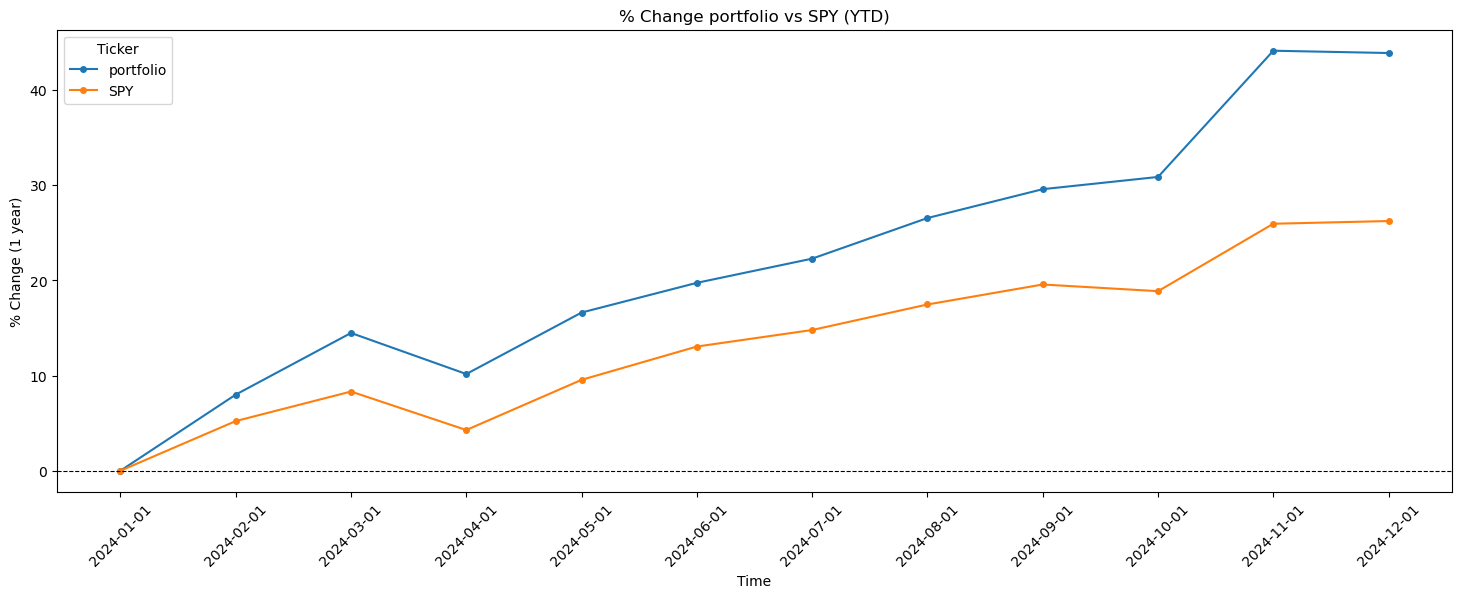

In [414]:
df_avgs = df_avgs.fillna(0)

plt.figure(figsize=(18, 6))
for ticker in df_avgs.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_avgs.columns[:-2],
        df_avgs.loc[ticker].values[:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (1 year)")
plt.title("% Change portfolio vs SPY (YTD)")
plt.xticks(rotation=45)
plt.show()